# Document type distribution

## Compare distribution of documents by type, and over time, in the following document populations:
- untagged 
- labelled
- filtered
- tagged to level 1 only
- tagged to level2 or lower

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import functools
import matplotlib as mpl
%matplotlib inline
inline_rc = dict(mpl.rcParams)

# Read in  data

In [2]:
#read in untagged content to describe content with no taxons
untagged = pd.read_csv('../../data/untagged_content.csv')
labelled = pd.read_csv('../../data/labelled.csv')
filtered = pd.read_csv('../../data/filtered.csv')
taxons = pd.read_csv('../../data/taxons_cleaner.csv')

In [3]:
#convert string dates to timestamp for time series analyses (see below)
print(type(untagged['first_published_at'][0]))
untagged['first_published_at'] = pd.to_datetime(untagged['first_published_at'])
print(type(untagged['first_published_at'][0]))

<class 'str'>
<class 'pandas._libs.tslib.Timestamp'>


In [4]:
#use timestamp as index in untagged data for plots
untagged.index = untagged['first_published_at'] 

### Document type groupings
These groupings have been devised by need and could be used to supplement this analysis or interpretation
https://gov-uk.atlassian.net/wiki/spaces/GFED/pages/187564388/Grouping+document+types+by+need
- __News and announcements__
    - Updates & alerts
    - News (promotions)
    - Marketing
    - Speeches
- __Guidance__
   - Guidance
   - Contacts
- __Service__
   - Transactions
- __Outcomes__
   - Reports
   - Decisions
- __Transparency__
   - Engagement activities
   - Data
- __Organising entities__
   - Organising entities
   - Support
- __Out of scope__
   - Navigation pages
   - Lists
- __Stand alone__
   - Corporate info
   - Service manual

In [5]:
#Consider grouping the individual doc types if further analyses required. 
#This would be performed in the cleaning scripts, as below:

# untagged['doc_type_gp'] = 'other'
# untagged.loc[untagged['doc_type'] == 'mobile', 'doc_type_gp'] = 'news_and_announcements'
# untagged.loc[untagged['doc_type'] == 'tablet', 'doc_type_gp'] = 'news_and_announcements'

## Frequency of documents in each category of document type

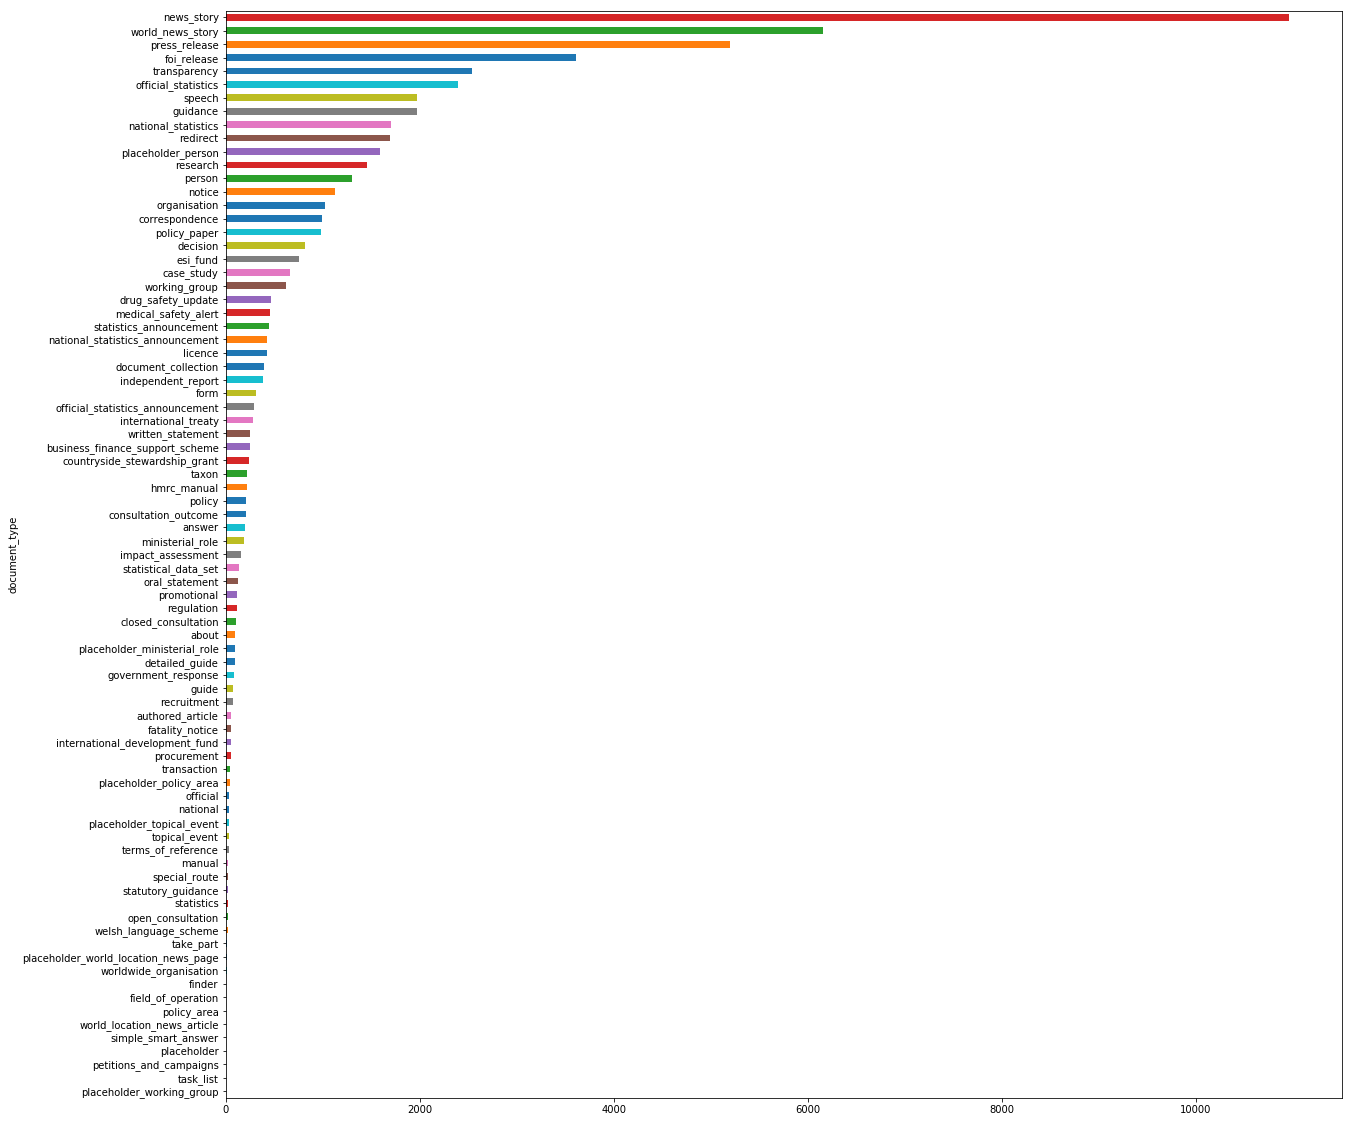

In [6]:
untagged.groupby('document_type').size().sort_values(ascending=True).plot(kind = 'barh', figsize=(20, 20))

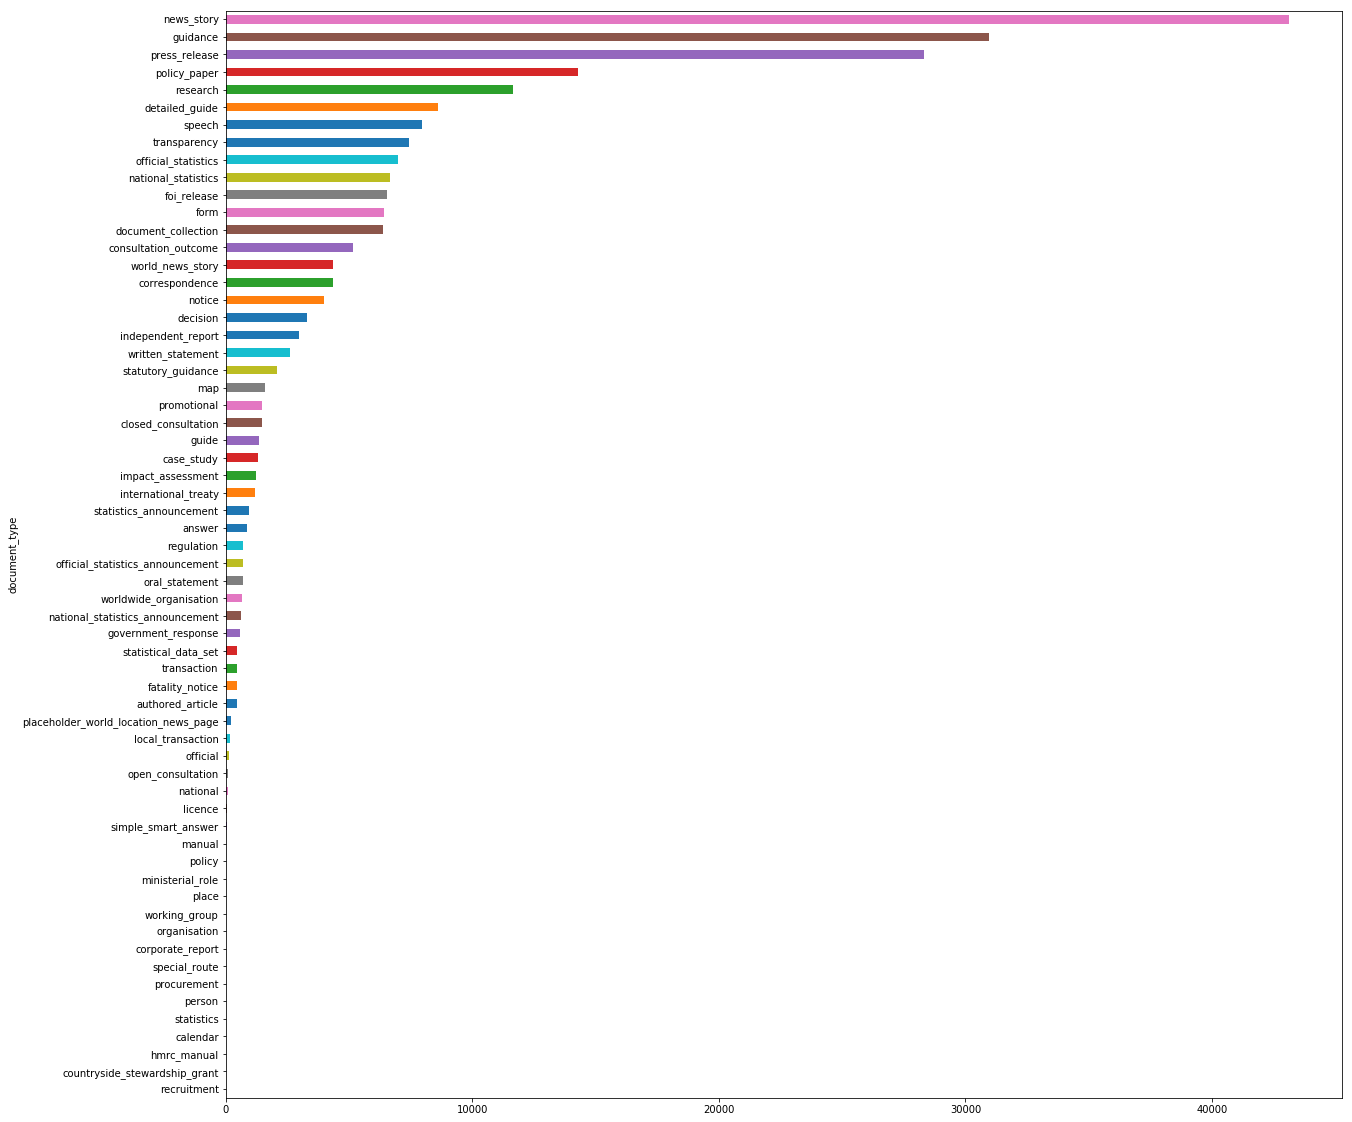

In [7]:
labelled.groupby('document_type').size().sort_values(ascending=True).plot(kind = 'barh', figsize=(20, 20))

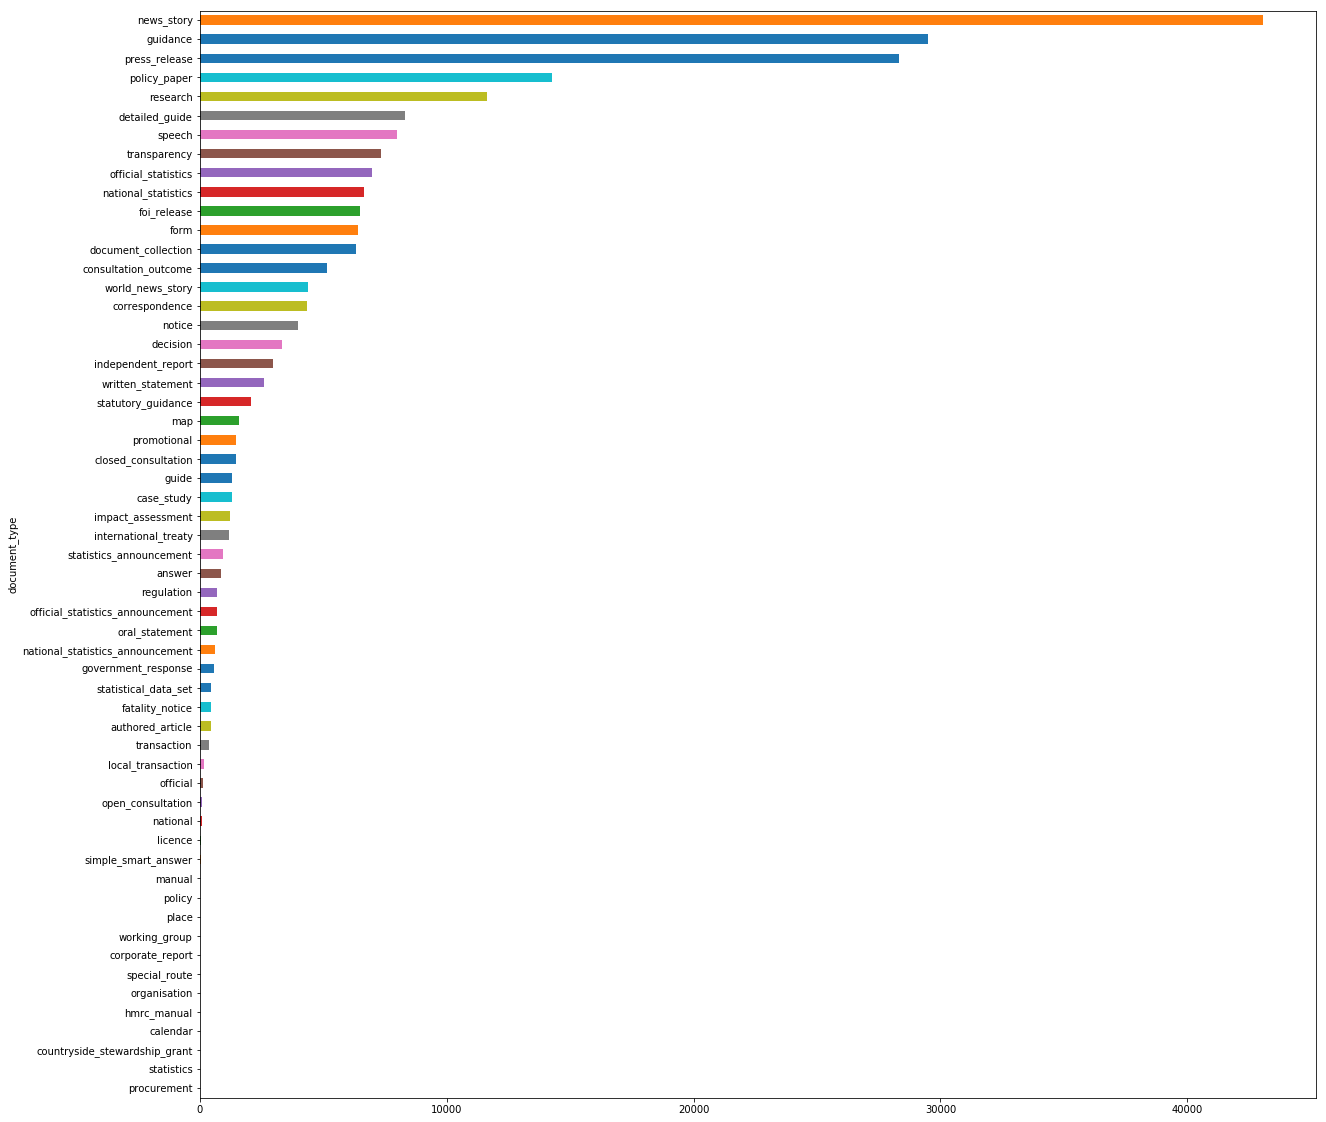

In [8]:
filtered.groupby('document_type').size().sort_values(ascending=True).plot(kind = 'barh', figsize=(20, 20))

### Observations/Conclusions
The untagged content appears to have a different distribution of document type compared to the tagged content, both before and after filtering the World/Corporate categories and deduplication. 

For example, relatively few guidance , policy paper and research documents are untagged. World_news_story, foi releases are over-represented in untagged data compared to tagged data.

This is likely to result in a drop inaccuracy when moving from modelling data to predicting for untagged data.

## Time series analyses of content type

What's the overall frequency of publications over time?

In [9]:
#untagged['first_published_at'].resample('Y').count().plot()

In [10]:
singlelabel = filtered.drop_duplicates('content_id').reset_index(drop=True)
print(singlelabel['first_published_at'][singlelabel['first_published_at'].str.contains('0001-01-01', na=False)])

singlelabel.drop(singlelabel.index[[58843]], inplace=True)
singlelabel['first_published_at'] = pd.to_datetime(singlelabel['first_published_at'])
singlelabel.index = singlelabel['first_published_at'] 

58843    0001-01-01T00:01:00.000+00:00
Name: first_published_at, dtype: object


Focus: since 2000

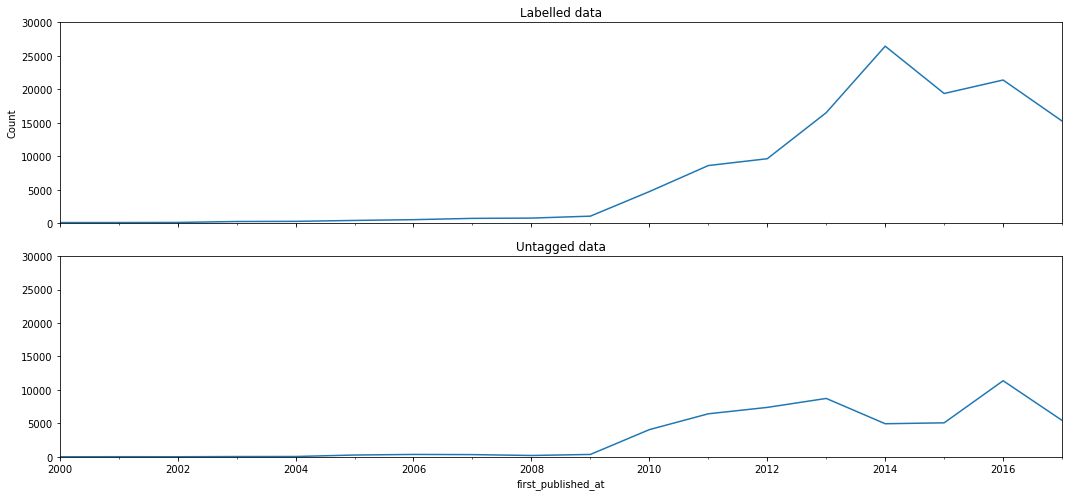

In [11]:
fig = plt.figure(figsize=(15, 7))
plt.subplot(2, 1, 1)
lab=singlelabel['first_published_at'].resample('Y').count().plot()
lab.set_xlim(pd.Timestamp('2000-12-31'), pd.Timestamp('2017-12-31'))
plt.title('Labelled data')
plt.ylabel('Count')
lab.set_ylim([0, 30000])
lab.axes.get_xaxis().set_ticklabels([])
lab.set_xlabel('')

plt.subplot(2, 1, 2)
plt.title('Untagged data')
unlab = untagged['first_published_at'].resample('Y').count().plot()
unlab.set_xlim(pd.Timestamp('2000-12-31'), pd.Timestamp('2017-12-31'))
unlab.set_ylim([0, 30000])

fig.tight_layout()


### What's the publication frequency over time by document type?
### Unlabelled

In [12]:
grouped = untagged.groupby(['document_type', pd.Grouper(freq='Y')])['first_published_at'].count()
count_by_year = grouped.unstack('document_type', fill_value=0)

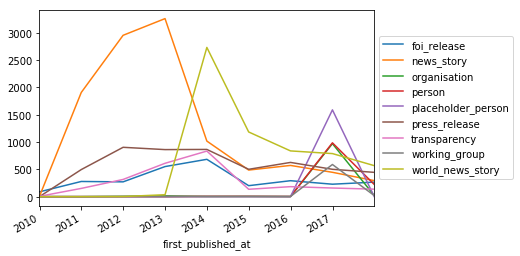

In [13]:
#There are too many document types to plot on one chart so select the types with highest maximum
top_count = count_by_year.loc[:,count_by_year.max() > 500]
ax = top_count.plot()
ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [14]:
#ax = grouped.unstack('document_type', fill_value=0).plot()
#ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

in order to compare distribution of document types over time with the labelled data, this needs to be relative not absolute. So change into percent of documents published that year

In [15]:
df = count_by_year.stack().reset_index()
df.columns = ['date', 'document_type', 'percent']
bydoctype_year = df.groupby(['date', 'document_type']).agg({'percent': 'sum'})
# Change: groupby state_office and divide by sum
bydoctype_pcts = bydoctype_year.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack('document_type', fill_value=0)

bydoctype_pcts.columns = bydoctype_pcts.columns.droplevel(0)
bydoctype_pcts.columns

Index(['about', 'answer', 'authored_article',
       'business_finance_support_scheme', 'case_study', 'closed_consultation',
       'consultation_outcome', 'correspondence',
       'countryside_stewardship_grant', 'decision', 'detailed_guide',
       'document_collection', 'drug_safety_update', 'esi_fund',
       'fatality_notice', 'field_of_operation', 'finder', 'foi_release',
       'form', 'government_response', 'guidance', 'guide', 'hmrc_manual',
       'impact_assessment', 'independent_report',
       'international_development_fund', 'international_treaty', 'licence',
       'manual', 'medical_safety_alert', 'ministerial_role', 'national',
       'national_statistics', 'national_statistics_announcement', 'news_story',
       'notice', 'official', 'official_statistics',
       'official_statistics_announcement', 'open_consultation',
       'oral_statement', 'organisation', 'person', 'petitions_and_campaigns',
       'placeholder_ministerial_role', 'placeholder_person',
       'pla

In [16]:

top_pct = bydoctype_pcts.loc[:,bydoctype_pcts.max() > 15]
print(top_pct.columns.values)

# ax = top_pct.plot(kind='area', stacked=True)

# ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.title("Labelled data")

['correspondence' 'decision' 'fatality_notice' 'foi_release' 'guidance'
 'independent_report' 'international_treaty' 'news_story' 'research'
 'world_news_story']


### Filtered

In [17]:
l_grouped = singlelabel.groupby(['document_type', pd.Grouper(freq='Y')])['first_published_at'].count()
l_count_by_year = l_grouped.unstack('document_type', fill_value=0)

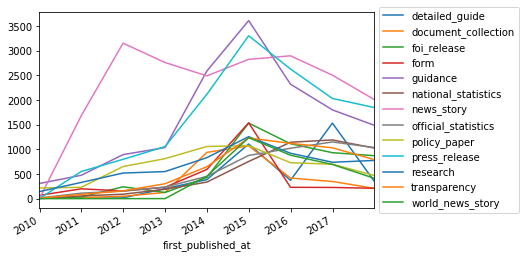

In [18]:
#There are too many document types to plot on one chart so select the types with highest maximum
l_top_count = l_count_by_year.loc[:,l_count_by_year.max() > 1000]
ax = l_top_count.plot()
ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [19]:
df_lab = l_count_by_year.stack().reset_index()
df_lab.columns = ['date', 'document_type', 'percent']
l_bydoctype_year = df_lab.groupby(['date', 'document_type']).agg({'percent': 'sum'})
# Change: groupby state_office and divide by sum
l_bydoctype_pcts = l_bydoctype_year.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack('document_type', fill_value=0)

l_bydoctype_pcts.columns = l_bydoctype_pcts.columns.droplevel(0)

In [20]:
l_top_pct = l_bydoctype_pcts[['correspondence', 'decision'
 , 'fatality_notice',  'foi_release',
  'guidance', 'independent_report', 'international_treaty', 'news_story', 'research', 'world_news_story']]

# ax = utop_pct.plot(kind='area', stacked=True)
# plt.title('Unlabelled')
# ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [21]:
type(l_bydoctype_pcts)

pandas.core.frame.DataFrame

#### level1tagged compared to level2tagged

In [22]:
#Only keep rows where level1/level2 combination is unique
level2_dedup = filtered.drop_duplicates(subset = ['content_id', 'level1taxon', 'level2taxon']).copy()

In [23]:
print(level2_dedup['first_published_at'][level2_dedup['first_published_at'].str.contains('0001-01-01', na=False)])
level2_dedup['first_published_at'] = level2_dedup['first_published_at'].str.replace('0001-01-01', '2001-01-01')

print("There were {} content item/taxons before removing duplicates".format(filtered.shape[0]))
print("There were {} content items, unique level2 taxon pairs after removing duplicates by content_id, level1taxon and level2taxon".format(level2_dedup.shape[0]))

#Identify and drop rows where level2 is missing
mask= pd.notnull(level2_dedup['level2taxon'])
level1_tagged = level2_dedup[~mask].copy()
print("There are {} content items only tagged to level1".format(level1_tagged.shape[0]))
level2_tagged = level2_dedup[mask].copy()
print("There are {} content items tagged to level2 or lower".format(level2_tagged.shape[0]))

print("{} + {} = {}".format(level1_tagged.shape[0], level2_tagged.shape[0], (level1_tagged.shape[0] + level2_tagged.shape[0])) )

68207     0001-01-01T00:01:00.000+00:00
121276    0001-01-01T00:01:00.000+00:00
127653    0001-01-01T00:01:00.000+00:00
152972    0001-01-01T00:01:00.000+00:00
Name: first_published_at, dtype: object
There were 229084 content item/taxons before removing duplicates
There were 203134 content items, unique level2 taxon pairs after removing duplicates by content_id, level1taxon and level2taxon
There are 32034 content items only tagged to level1
There are 171100 content items tagged to level2 or lower
32034 + 171100 = 203134


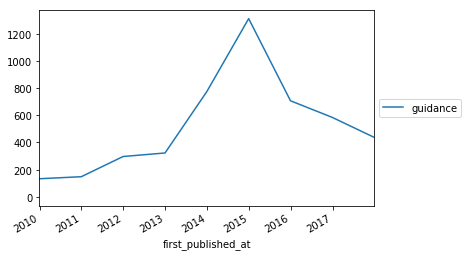

In [24]:
#level1
level1_tagged['first_published_at'] = pd.to_datetime(level1_tagged['first_published_at'])
level1_tagged.index = level1_tagged['first_published_at']


l1_grouped = level1_tagged.groupby(['document_type', pd.Grouper(freq='Y')])['first_published_at'].count()
l1_count_by_year = l1_grouped.unstack('document_type', fill_value=0)
#There are too many document types to plot on one chart so select the types with highest maximum
l1_top_count = l1_count_by_year.loc[:,l1_count_by_year.max() > 1000]

ax = l1_top_count.plot()
ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [25]:
df_l1 = l1_count_by_year.stack().reset_index()
df_l1.columns = ['date', 'document_type', 'percent']
l1_bydoctype_year = df_l1.groupby(['date', 'document_type']).agg({'percent': 'sum'})
# Change: groupby state_office and divide by sum
l1_bydoctype_pcts = l1_bydoctype_year.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack('document_type', fill_value=0)

l1_bydoctype_pcts.columns = l1_bydoctype_pcts.columns.droplevel(0)
l1_top_pct = l1_bydoctype_pcts.loc[:,l1_bydoctype_pcts.max() > 20]
l1_top_pct.columns.values

array(['decision', 'fatality_notice', 'guidance', 'independent_report',
       'international_treaty', 'national_statistics', 'notice',
       'policy_paper', 'research', 'statutory_guidance'], dtype=object)

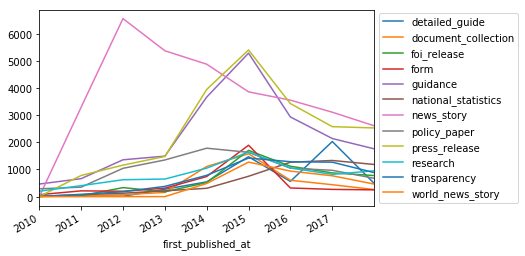

In [26]:
#level2
level2_tagged['first_published_at'] = pd.to_datetime(level2_tagged['first_published_at'])
level2_tagged.index = level2_tagged['first_published_at']


l2_grouped = level2_tagged.groupby(['document_type', pd.Grouper(freq='Y')])['first_published_at'].count()
l2_count_by_year = l2_grouped.unstack('document_type', fill_value=0)
#There are too many document types to plot on one chart so select the types with highest maximum
l2_top_count = l2_count_by_year.loc[:,l2_count_by_year.max() > 1200]

#Graph (absolute numbers)
ax = l2_top_count.plot()
ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [27]:
#Relative
df_l2 = l2_count_by_year.stack().reset_index()
df_l2.columns = ['date', 'document_type', 'percent']
l2_bydoctype_year = df_l2.groupby(['date', 'document_type']).agg({'percent': 'sum'})
# Change: groupby state_office and divide by sum
l2_bydoctype_pcts = l2_bydoctype_year.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack('document_type', fill_value=0)

l2_bydoctype_pcts.columns = l2_bydoctype_pcts.columns.droplevel(0)
l2_top_pct = l2_bydoctype_pcts[['decision', 'fatality_notice', 'guidance', 'independent_report',
       'international_treaty', 'national_statistics', 'notice',
       'policy_paper', 'research', 'statutory_guidance']]

Text(0.5,1,'Percent level2')

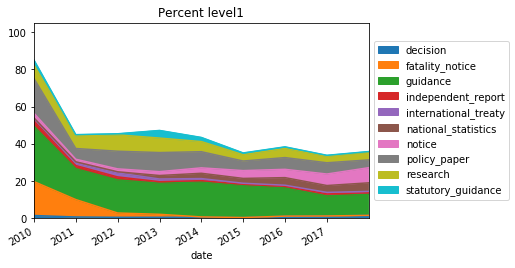

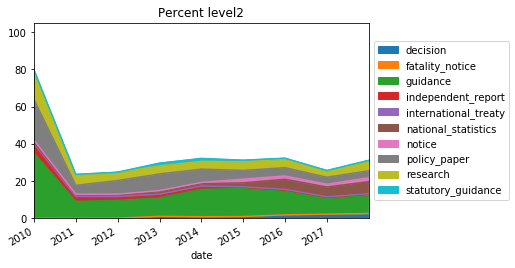

In [28]:
#Compare document type distribution over time beween content items tagged to level1 only and those tagged to level2 or lower
lev1 = l1_top_pct.plot(kind='area', stacked=True)
lev1.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
lev1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Percent level1")

lev2 = l2_top_pct.plot(kind='area', stacked=True)
lev2.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
lev2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Percent level2")

## Compare labelled/unlabelled

Text(0.5,1,'Percent labelled')

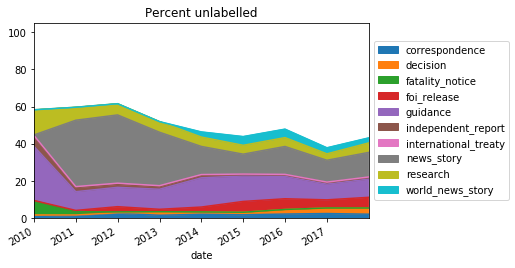

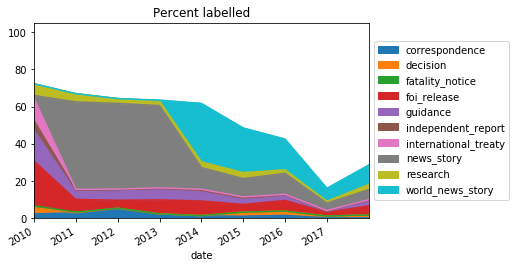

In [29]:
#TO DO: SORT OUT SUBPLOTS
lab = l_top_pct.plot(kind='area', stacked=True)
lab.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
lab.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Percent unlabelled")

unlab = top_pct.plot(kind='area', stacked=True)
unlab.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
unlab.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Percent labelled")

## Other metadata

### Untagged

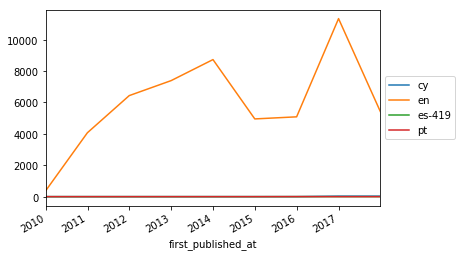

In [30]:
inline_rc = dict(mpl.rcParams)
grouped = untagged.groupby(['locale', pd.Grouper(freq='Y')])['first_published_at'].count()
count_by_year = grouped.unstack('locale', fill_value=0)

ax = count_by_year.plot()
ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Publishing App
#### untagged

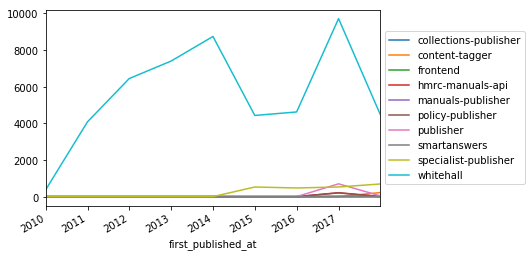

In [31]:
grouped = untagged.groupby(['publishing_app', pd.Grouper(freq='Y')])['first_published_at'].count()
count_by_year = grouped.unstack('publishing_app', fill_value=0)

ax = count_by_year.plot()
ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#### Filtered

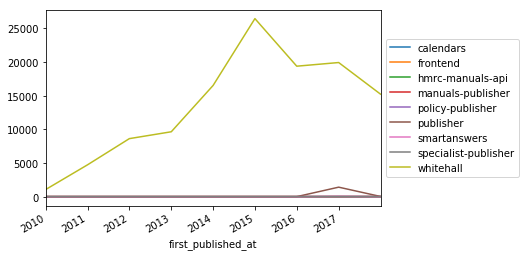

In [32]:
grouped = singlelabel.groupby(['publishing_app', pd.Grouper(freq='Y')])['first_published_at'].count()
count_by_year = grouped.unstack('publishing_app', fill_value=0)

ax = count_by_year.plot()
ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#### level1 tagged

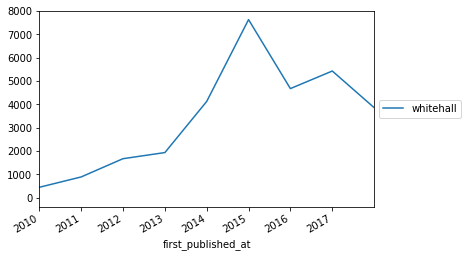

In [33]:
grouped = level1_tagged.groupby(['publishing_app', pd.Grouper(freq='Y')])['first_published_at'].count()
count_by_year = grouped.unstack('publishing_app', fill_value=0)

ax = count_by_year.plot()
ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#### level2 tagged

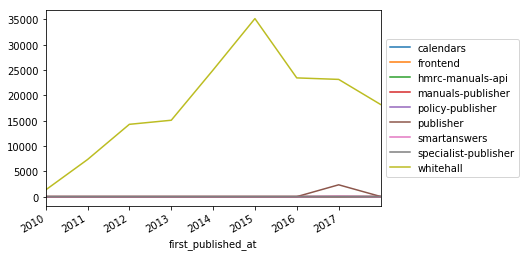

In [34]:
grouped = level2_tagged.groupby(['publishing_app', pd.Grouper(freq='Y')])['first_published_at'].count()
count_by_year = grouped.unstack('publishing_app', fill_value=0)

ax = count_by_year.plot()
ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### primary publishing organisation

#### untagged

Text(0.5,1,'Percent unlabelled')

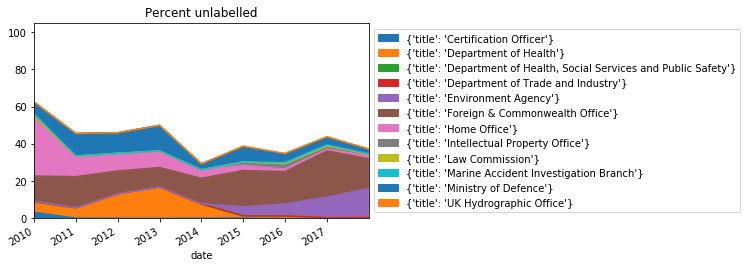

In [35]:
grouped = untagged.groupby(['primary_publishing_organisation', pd.Grouper(freq='Y')])['first_published_at'].count()
count_by_year = grouped.unstack('primary_publishing_organisation', fill_value=0)
# ax = count_by_year.plot()
# ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

df = count_by_year.stack().reset_index()
df.columns = ['date', 'primary_publishing_organisation', 'percent']
bydoctype_year = df.groupby(['date', 'primary_publishing_organisation']).agg({'percent': 'sum'})
# Change: groupby state_office and divide by sum
bydoctype_pcts = bydoctype_year.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack('primary_publishing_organisation', fill_value=0)

bydoctype_pcts.columns = bydoctype_pcts.columns.droplevel(0)
top_pct = bydoctype_pcts.loc[:,bydoctype_pcts.max() > 15]
top_pct.columns.values

lab = top_pct.plot(kind='area', stacked=True)
lab.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
lab.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Percent unlabelled")

To DO: 
- work out subplots
- Look at differences in publishin body/publishing app/ locale/tokenised sequence length over time  
- Tidy up notebook
